In [ ]:
# default_exp data

# DICOM preprocessing methods

> ...

In [1]:
from nbdev import *

In [2]:
# export

import os
import random
from scipy.ndimage import zoom
import numpy as np
import SimpleITK as sitk
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [3]:
# export

from sklearn.cluster import KMeans
from skimage import morphology
from skimage import measure

from lunglens.data import read_dicom_folder, read_dicom_file, print_slice, print_hist, appply_window
#from skimage.transform import resize
from scipy.interpolate import interp2d


### the scan preperation flow

In [37]:
# export

def prepare_scan(scan_folder, slice_size=512, window=[-600, 900], show_stages=False):
    
    # read the scan
    data, itk_image = read_dicom_folder(scan_folder)
    nrows, ncols = data.shape[1:3]
    ytags = np.linspace(0, nrows, slice_size)
    xtags = np.linspace(0, ncols, slice_size)

    # resize all images in the scan
    scan_resized = np.zeros((data.shape[0], slice_size, slice_size))
    for i in range(data.shape[0]):
        f = interp2d(np.arange(nrows), np.arange(ncols), data[i])
        scan_resized[i] = f(ytags, xtags)
    
    # radiological window and normalize
    scan = appply_window(scan_resized, l=window[0], w=window[1]-window[0], normalize=True)
    
    # show random slice
    if show_stages:
        fig, ax = plt.subplots(2, 2, figsize=[10, 10])
        slice_idx = np.random.randint(scan.shape[0])
        ax[0, 0].set_title('not windowed')
        ax[0, 1].set_title('windowed')
        ax[1, 0].set_title('slice ' + str(slice_idx))
        ax[1, 1].set_title('slice ' + str(slice_idx))
        ax[0, 0].hist(scan_resized[0].flatten(), bins=100)
        ax[0, 1].hist(scan[0].flatten(), bins=100)
        ax[1, 0].imshow(scan_resized[slice_idx], cmap='gray')
        ax[1, 1].imshow(scan[slice_idx], cmap='gray')
        plt.show()
    
    return scan

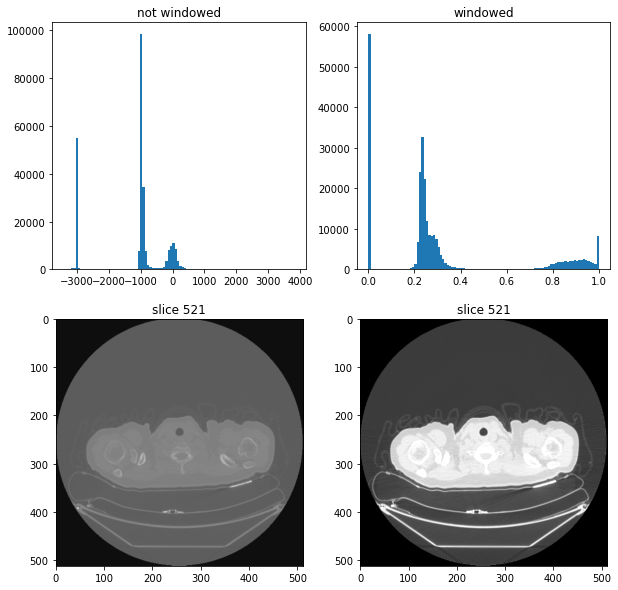

(1018, 512, 512)


In [66]:
ds_dir = Path('../data/extracted/osic-pulmonary-fibrosis-progression')
all_files = list(ds_dir.rglob('ID0*'))
random_scan = random.choice(all_files)
#random_scan = '../data/extracted/osic-pulmonary-fibrosis-progression/ID00388637202301028491611'
random_scan = '../data/extracted/osic-pulmonary-fibrosis-progression/ID00078637202199415319443'

scan = prepare_scan(random_scan, show_stages=True)
print(scan.shape)

### define segmentation tools

In [76]:
# export

def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    print(centers)
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    #print('label_vals:', label_vals)
    #print(len(regions))
    good_labels = []
    for prop in regions:
        B = prop.bbox
        #print(prop.label, ':', B)
        #if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
        span_ok =  B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9
        margin_ok = B[0]>row_size/10 and B[2]<col_size/10*9
        if span_ok and margin_ok:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    print('good_labels:', good_labels)
    if len(good_labels) > 3:
        # take up to 3 dominant regions (menashe, oct.3)
        label_weight = [np.where(labels==N,1,0).sum() for N in good_labels]
        good_labels = [good_labels[i] for i in np.argsort(label_weight)[-3:]]
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask #mask*img


segment slice 87
[-0.10975453454543449, 1.7918693225255342]
good_labels: [2, 3, 4, 5, 6, 7, 8]


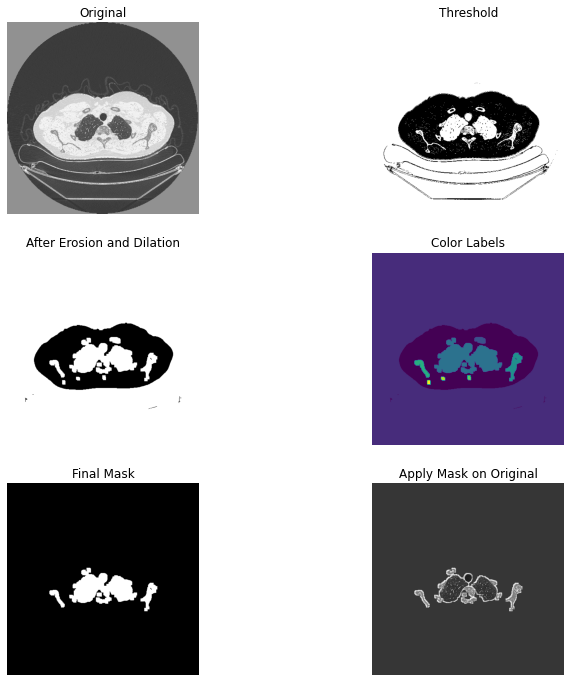

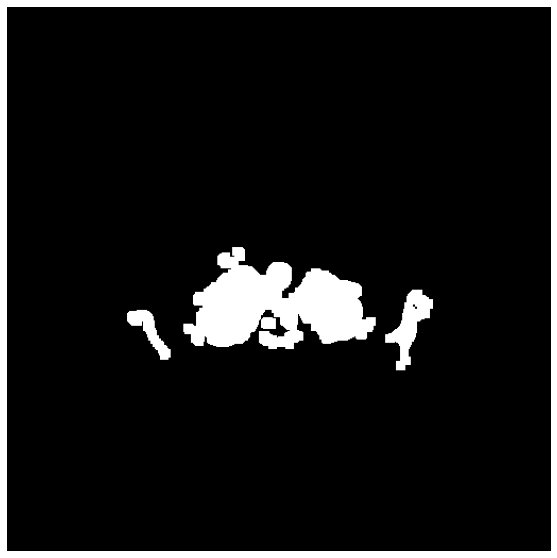

In [77]:
slice_idx = np.random.randint(scan.shape[0])
slice_idx = 87
print('segment slice', slice_idx)
mask = make_lungmask(scan[slice_idx], display=True)
print_slice(mask)

### get tiles from mask

In [78]:
# export

def get_tiles(img, mask, tile_size, show_tiling=False):
    
    tile_num_pixels = tile_size * tile_size
    thd_pop = tile_num_pixels * 0.25
    
    # create grid of partialy overlapping tiles
    sets = 1 
    tile_left_coor = np.arange(0, mask.shape[0]-tile_size+1, int(tile_size / sets), dtype=int)
    tile_upper_coor = np.arange(0, mask.shape[1]-tile_size+1, int(tile_size / sets), dtype=int)
    # tile_left_coor = tile_left_coor.reshape([-1, sets]).T
    # tile_upper_coor = tile_upper_coor.reshape([-1, sets]).T
    print(tile_left_coor, '\n', tile_upper_coor, '\n\n TBD VALIDITY CHECK\n\n')
    
    # select sub-grid with best coverage
    tiles = []
    if show_tiling:
        tile_map = np.zeros(mask.shape)
        tile_img = np.copy(img)
    for i_left in tile_left_coor:
        for i_upper in tile_upper_coor:
            tile_mask = mask[i_upper:i_upper+tile_size, i_left:i_left+tile_size]
            if tile_mask.sum() > thd_pop:
                tiles.append(img[i_upper:i_upper+tile_size, i_left:i_left+tile_size] * tile_mask)
                if show_tiling:
                    tile_map[i_upper:i_upper+tile_size, i_left:i_left+tile_size] = 0.5
                    tile_img[i_upper:i_upper+tile_size, i_left:i_left+tile_size] *= 2
    
    # visualize tiling
    if show_tiling:
        tile_map += mask
        for i_left in tile_left_coor:
            tile_map[:, i_left] = 2
            tile_img[:, i_left] = 2
            for i_upper in tile_upper_coor:
                tile_map[i_upper, :] = 2
                tile_img[i_upper, :] = 2
        print_slice(tile_map)
        print_slice(tile_img)

    
    # take the grids that include enough pixels
    
    return tiles
    

(512, 512)
[  0  64 128 192 256 320 384 448] 
 [  0  64 128 192 256 320 384 448] 

 TBD VALIDITY CHECK




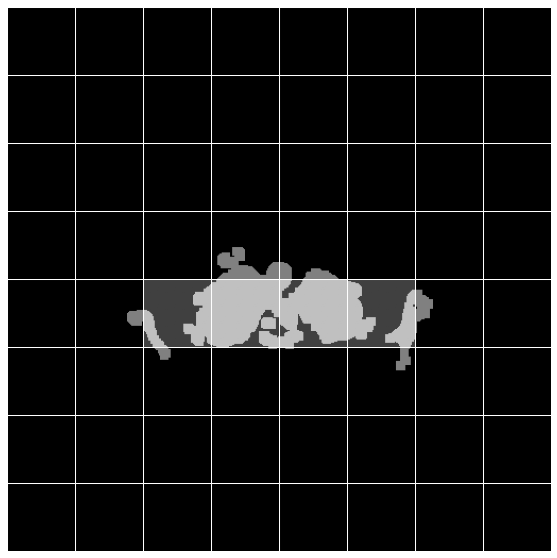

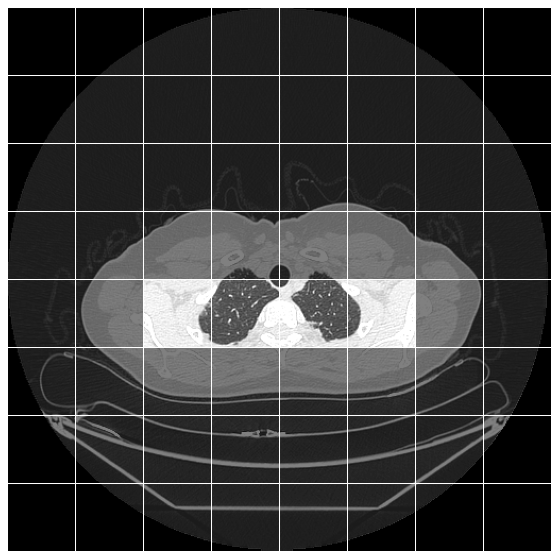

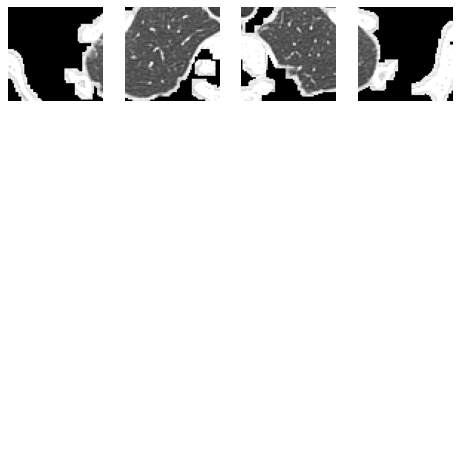

In [79]:
print(scan[slice_idx].shape)
tiles = get_tiles(scan[slice_idx], mask, 64, show_tiling=True)
fig, ax = plt.subplots(4, 4, figsize=[8, 8])
for i, tile in enumerate(tiles):
    ax[int(i/4), i % 4].imshow(tile, cmap='gray')
for i in range(16):
    ax[int(i/4), i % 4].axis('off')
plt.show()

## now show the complete flow




going to read and proces ../data/extracted/osic-pulmonary-fibrosis-progression/ID00078637202199415319443


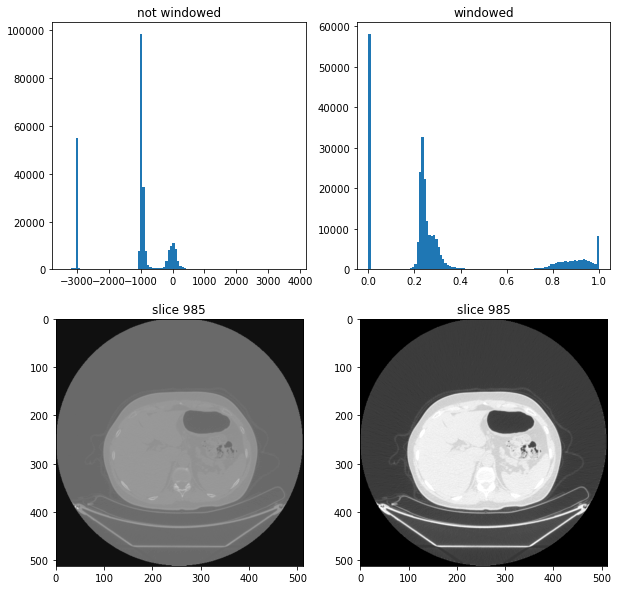

(1018, 512, 512)



going to segment slice 87 

good_labels: [2, 3, 4, 5, 6, 7, 8]


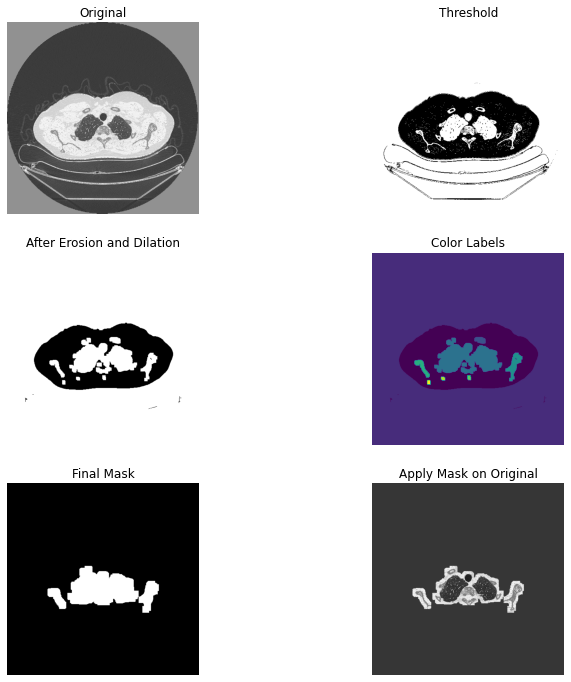




[  0  64 128 192 256 320 384 448] 
 [  0  64 128 192 256 320 384 448] 

 TBD VALIDITY CHECK




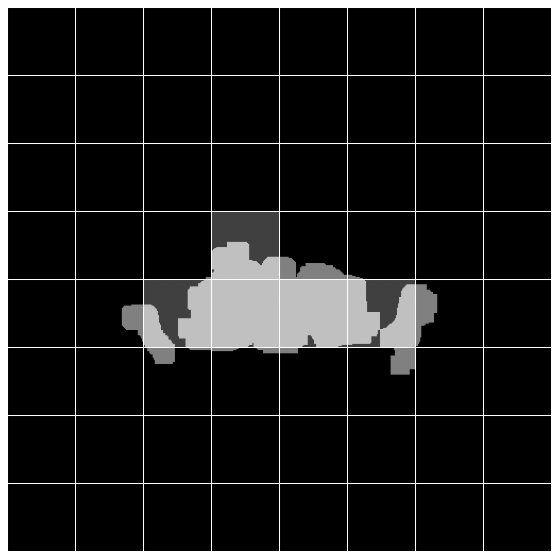

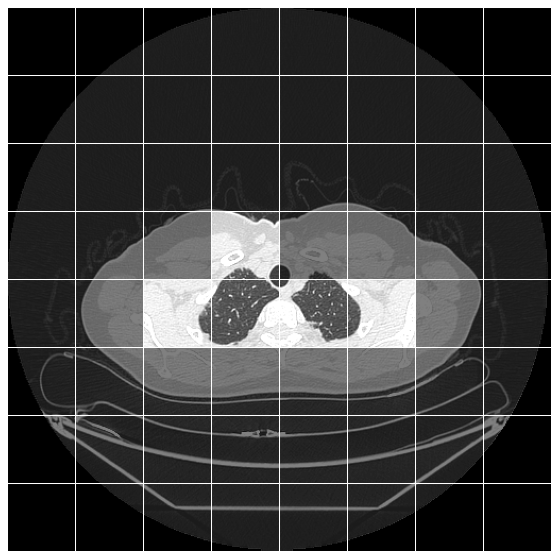

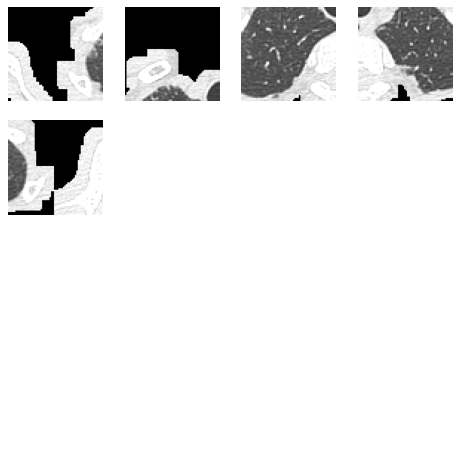

In [65]:
if __name__ == "__main__":
    
    ds_dir = Path('../data/extracted/osic-pulmonary-fibrosis-progression')
    all_files = list(ds_dir.rglob('ID0*'))
    random_scan = random.choice(all_files)
    #random_scan = '../data/extracted/osic-pulmonary-fibrosis-progression/ID00388637202301028491611'
    random_scan = '../data/extracted/osic-pulmonary-fibrosis-progression/ID00078637202199415319443'

    print('\n\n\ngoing to read and proces', random_scan)
    scan = prepare_scan(random_scan, slice_size=512, window=[-600, 900], show_stages=True)
    print(scan.shape)
    
    slice_idx = np.random.randint(scan.shape[0])
    slice_idx = 87
    print('\n\n\ngoing to segment slice', slice_idx, '\n')
    mask = make_lungmask(scan[slice_idx], display=True)
    
    print('\n\n')
    tiles = get_tiles(scan[slice_idx], mask, 64, show_tiling=True)
    fig, ax = plt.subplots(4, 4, figsize=[8, 8])
    for i, tile in enumerate(tiles):
        ax[int(i/4), i % 4].imshow(tile, cmap='gray')
    for i in range(16):
        ax[int(i/4), i % 4].axis('off')
    plt.show()